In [1]:
import numpy as np 
import pandas as pd 
import os
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import random
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [2]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=efdc225787aa45ecd6d7fafa4053c98f1f36bb7ab311c9d42b6bc6cbcf1461f0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e497ea7cfed07814e62d7ddb21f827cbbc9f7c469a42631ba99ffc59c867bc8f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import random

dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
augmented_dataset_path = "/kaggle/working/augmented_dataset"  
possible_augmentations = [
    transforms.RandomHorizontalFlip(p=1.0),  
    transforms.RandomRotation(degrees=30),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  
    transforms.RandomPerspective(distortion_scale=0.4, p=1.0),  
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 3.0)),  
]

original_dataset = ImageFolder(root=dataset_path)
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

for class_name in original_dataset.classes:
    os.makedirs(os.path.join(augmented_dataset_path, class_name), exist_ok=True)

num_augmentations = 8  
for img_path, label in original_dataset.samples:
    img = Image.open(img_path).convert("RGB")
    class_name = original_dataset.classes[label]
    save_dir = os.path.join(augmented_dataset_path, class_name)

    img.save(os.path.join(save_dir, os.path.basename(img_path)))
    for i in range(num_augmentations):
        selected_augmentations = random.sample(possible_augmentations, k=random.randint(1, 3)) 
        transform_pipeline = transforms.Compose([transforms.Resize((227, 227))] + selected_augmentations)  
        
        augmented_img = transform_pipeline(img)
        save_path = os.path.join(save_dir, f"aug_{i}_{os.path.basename(img_path)}")
        augmented_img.save(save_path)

print(f"Dataset is completely augmented ")

In [4]:
import shutil
import os

def zip_folder(folder_path, output_zip_path):
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return
    shutil.make_archive(output_zip_path, 'zip', folder_path)
    print(f"Folder '{folder_path}' has been zipped to '{output_zip_path}.zip'")

zip_folder("/kaggle/working/augmented_dataset", "/kaggle/working/augmented_dataset_zip_file")
print(f"successfully zipped")

In [5]:
augmented_dataset_path = "/kaggle/input/thermal-dataset"

In [6]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((227, 227)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
augmented_dataset = ImageFolder(root=augmented_dataset_path, transform=transform)
train_size = int(0.6 * len(augmented_dataset))
val_size = int(0.2 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(augmented_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

num_ftrs = model.classifier[1].in_features
num_classes = 6
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

num_epochs = 70
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_acc_history.append(train_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

torch.save(model.state_dict(), "efficientnet_b0_trained.pth")
print("\nModel saved as efficientnet_b0_trained.pth")


Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 106MB/s]
<ipython-input-7-64d612555a99>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/70:   0%|          | 0/108 [00:00<?, ?it/s]<ipython-input-7-64d612555a99>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/70, Loss: 1.6573, Accuracy: 32.18%


Epoch 2/70, Loss: 1.5279, Accuracy: 41.32%


Epoch 3/70, Loss: 1.4472, Accuracy: 45.69%


Epoch 4/70, Loss: 1.3855, Accuracy: 49.33%


Epoch 5/70, Loss: 1.3322, Accuracy: 51.69%


Epoch 6/70, Loss: 1.2802, Accuracy: 54.25%


Epoch 7/70, Loss: 1.2473, Accuracy: 54.89%


Epoch 8/70, Loss: 1.2019, Accuracy: 57.25%


Epoch 9/70, Loss: 1.1687, Accuracy: 58.04%


Epoch 10/70, Loss: 1.1434, Accuracy: 60.57%


Epoch 11/70, Loss: 1.1160, Accuracy: 61.97%


Epoch 12/70, Loss: 1.0819, Accuracy: 62.55%


Epoch 13/70, Loss: 1.0596, Accuracy: 63.48%


Epoch 14/70, Loss: 1.0495, Accuracy: 65.00%


Epoch 15/70, Loss: 1.0306, Accuracy: 65.23%


Epoch 16/70, Loss: 1.0117, Accuracy: 66.37%


Epoch 17/70, Loss: 1.0034, Accuracy: 66.66%


Epoch 18/70, Loss: 0.9768, Accuracy: 66.92%


Epoch 19/70, Loss: 0.9684, Accuracy: 67.01%


Epoch 20/70, Loss: 0.9656, Accuracy: 68.03%


Epoch 21/70, Loss: 0.9348, Accuracy: 68.43%


Epoch 22/70, Loss: 0.9350, Accuracy: 67.97%


Epoch 23/70, Loss: 0.9222, Accuracy: 69.86%


Epoch 24/70, Loss: 0.8982, Accuracy: 70.47%


Epoch 25/70, Loss: 0.8959, Accuracy: 70.47%


Epoch 26/70, Loss: 0.8774, Accuracy: 71.11%


Epoch 27/70, Loss: 0.8887, Accuracy: 70.27%


Epoch 28/70, Loss: 0.8672, Accuracy: 70.36%


Epoch 29/70, Loss: 0.8600, Accuracy: 71.17%


Epoch 30/70, Loss: 0.8589, Accuracy: 71.61%


Epoch 31/70, Loss: 0.8460, Accuracy: 71.69%


Epoch 32/70, Loss: 0.8332, Accuracy: 72.98%


Epoch 33/70, Loss: 0.8333, Accuracy: 71.81%


Epoch 34/70, Loss: 0.8316, Accuracy: 71.81%


Epoch 35/70, Loss: 0.8218, Accuracy: 72.16%


Epoch 36/70, Loss: 0.8099, Accuracy: 72.89%


Epoch 37/70, Loss: 0.8167, Accuracy: 72.45%


Epoch 38/70, Loss: 0.8059, Accuracy: 73.38%


Epoch 39/70, Loss: 0.7972, Accuracy: 74.14%


Epoch 40/70, Loss: 0.8009, Accuracy: 73.38%


Epoch 41/70, Loss: 0.7804, Accuracy: 73.76%


Epoch 42/70, Loss: 0.7817, Accuracy: 74.46%


Epoch 43/70, Loss: 0.7831, Accuracy: 73.44%


Epoch 44/70, Loss: 0.7798, Accuracy: 73.53%


Epoch 45/70, Loss: 0.7801, Accuracy: 74.40%


Epoch 46/70, Loss: 0.7755, Accuracy: 73.68%


Epoch 47/70, Loss: 0.7599, Accuracy: 74.11%


Epoch 48/70, Loss: 0.7619, Accuracy: 74.78%


Epoch 49/70, Loss: 0.7486, Accuracy: 75.42%


Epoch 50/70, Loss: 0.7651, Accuracy: 75.31%


Epoch 51/70, Loss: 0.7455, Accuracy: 74.69%


Epoch 52/70, Loss: 0.7508, Accuracy: 74.14%


Epoch 53/70, Loss: 0.7346, Accuracy: 74.93%


Epoch 54/70, Loss: 0.7223, Accuracy: 75.71%


Epoch 55/70, Loss: 0.7452, Accuracy: 74.72%


Epoch 56/70, Loss: 0.7223, Accuracy: 76.00%


Epoch 57/70, Loss: 0.7419, Accuracy: 74.26%


Epoch 58/70, Loss: 0.7196, Accuracy: 75.86%


Epoch 59/70, Loss: 0.7162, Accuracy: 75.25%


Epoch 60/70, Loss: 0.7042, Accuracy: 76.47%


Epoch 61/70, Loss: 0.7160, Accuracy: 76.18%


Epoch 62/70, Loss: 0.7125, Accuracy: 76.65%


Epoch 63/70, Loss: 0.7093, Accuracy: 76.24%


Epoch 64/70, Loss: 0.7134, Accuracy: 75.28%


Epoch 65/70, Loss: 0.7147, Accuracy: 76.00%


Epoch 66/70, Loss: 0.6955, Accuracy: 76.47%


Epoch 67/70, Loss: 0.7007, Accuracy: 76.59%


Epoch 68/70, Loss: 0.7127, Accuracy: 75.63%


Epoch 69/70, Loss: 0.6905, Accuracy: 76.41%


Epoch 70/70, Loss: 0.6991, Accuracy: 75.83%

Model saved as efficientnet_b0_trained.pth


In [8]:
import numpy as np
import torch

class_names = augmented_dataset.classes  
num_classes = len(class_names)  

def calculate_per_class_accuracy(model, data_loaders, device, datasets=["Training", "Validation", "Test"]):
    for dataset_type, data_loader in zip(datasets, data_loaders):
        model.eval()
        class_correct = np.zeros(num_classes) 
        class_total = np.zeros(num_classes)

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

        print(f"\n Final Per-Class {dataset_type} Accuracy:\n")
        for i in range(num_classes):  
            if class_total[i] > 0:
                accuracy = 100 * class_correct[i] / class_total[i]
                print(f"{class_names[i]}: {dataset_type} = {accuracy:.2f}%")
            else:
                print(f"{class_names[i]}: {dataset_type} = No samples available ")

data_loaders = [train_loader, val_loader, test_loader]
datasets = ["Training", "Validation", "Test"]
calculate_per_class_accuracy(model, data_loaders, device, datasets=datasets)


 Final Per-Class Training Accuracy:

BLB: Training = 86.29%
Blast: Training = 66.11%
healthy: Training = 84.34%
hispa: Training = 87.13%
leaf folder: Training = 92.43%
leaf spot: Training = 76.29%

 Final Per-Class Validation Accuracy:

BLB: Validation = 82.28%
Blast: Validation = 62.50%
healthy: Validation = 76.40%
hispa: Validation = 80.99%
leaf folder: Validation = 88.52%
leaf spot: Validation = 66.67%

 Final Per-Class Test Accuracy:

BLB: Test = 80.72%
Blast: Test = 54.20%
healthy: Test = 74.53%
hispa: Test = 80.49%
leaf folder: Test = 90.00%
leaf spot: Test = 67.30%


Test Accuracy: 75.39%


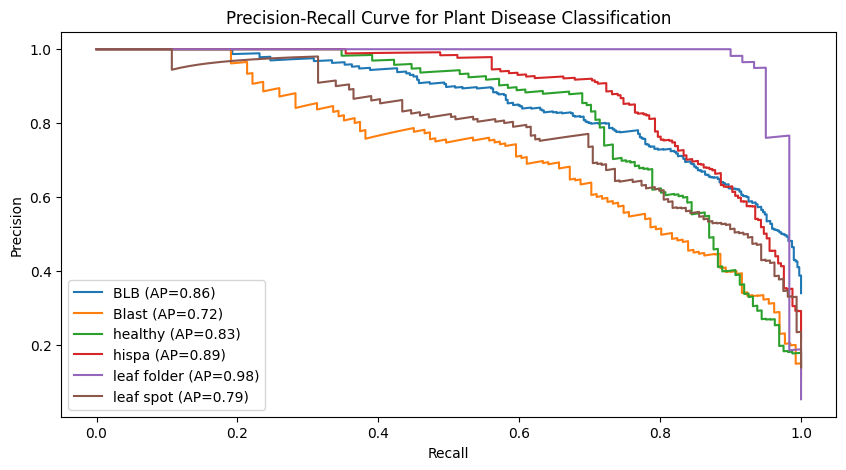

In [9]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
y_true = []
y_scores = []
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

plt.figure(figsize=(10, 5))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    avg_precision = average_precision_score(y_true == i, y_scores[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Plant Disease Classification")
plt.legend()
plt.show()

In [10]:
""" 

UNet, Resnet, SegNet, GoogleNet, VGG, AlexNet, IncepTon V3, R-CNN, YOLOv11,
ViT, EfficientNetv2
"""

' \n\nUNet, Resnet, SegNet, GoogleNet, VGG, AlexNet, IncepTon V3, R-CNN, YOLOv11,\nViT, EfficientNetv2\n'

In [11]:
# alexnet , resnet , googlenet , unet , vgg
# segnet , inception , rcnn , vit  , efficient net